# Fisher information applied to FPM
According to the Cramer-Rao inequality, the covariance matrix of an estimator is bounded by the inverse of the Fisher Information Matrix (FIM)

$C(\theta) \leq \bf{I}^{-1} (\theta)$



## FIM of a Poisson
$f(x|\lambda) = \frac{\lambda^{x} e^{-\lambda}}{x!}$

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, fftshift

from fpmsample.simicro import SimMicroscope, NoiseModel
from fpmsample import data, shapes
from phasemath.math import SimImage
import fpmsample.shapes as shapes

lam = 1
n=10
x = np.random.poisson(lam=lam, size=n)
# it = n*ix
ix = 1/lam
it = n/lam

So the CRLB for the estimators of $\lambda$ is $CRB(\lambda) = \mathcal{I}^{-1}(\lambda)=\lambda/n$

## Applied to an image sensor
Let's begin by implementing the fundamental model, where the only source of randomness lies in the poisson noise of the photon arrival. In this case, the information matrix is

\begin{equation}
\mathcal{I}(\theta) = \int_{t_0}^{t}\int_{\mathcal{R}^2} \frac{1}{\Lambda_{\theta}(\tau) f_{\theta, \tau}(x, y)} \left( \frac{\partial[\Lambda_\theta (\tau) f_{\theta, \tau}(x, y)]}{\partial\theta}\right)^T \left( \frac{\partial[\Lambda_\theta (\tau) f_{\theta, \tau}(x, y)]}{\partial\theta}\right) dx dy d\tau
\end{equation}

## Generating Noisy images

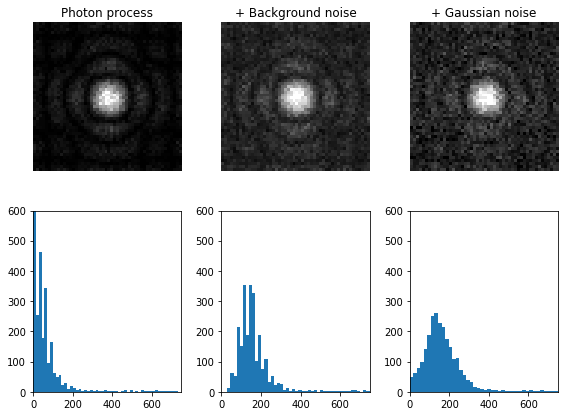

In [2]:
def cn(image_array, expossure_time=1e-1, sigmar=0, dD=0):
    gaussian_noise = np.random.normal(0, sigmar, size)
    lambdas = (np.abs(image_array)+dD)*expossure_time
    noisy_image = np.random.poisson(lam=lambdas, size=image_array.shape)+gaussian_noise
    noisy_image = noisy_image/expossure_time
    return noisy_image
size = (50, 50)
lam = 30
s = shapes.Circle(dim=50, radius=4, ft=True).draw(0, 0)*1000
cns = cn(s)
cnsd = cn(s,dD=100)
cnsdn = cn(s, dD=100,sigmar=5)

fig, axes = plt.subplots(2, 3, figsize=(8, 6))
axes[0][0].imshow(cns,  cmap='gray', vmin=0, vmax=1e3)
axes[0][0].set_title('Photon process')
axes[0][1].imshow(cnsd, cmap='gray', vmin=0, vmax=1e3)
axes[0][1].set_title('+ Background noise')
axes[0][2].imshow(cnsdn, cmap='gray', vmin=0, vmax=1e3)
axes[0][2].set_title('+ Gaussian noise')
for ax in axes[0]:
    ax.axis('off')
axes[1][0].hist(cns.ravel(), bins=80)
axes[1][1].hist(cnsd.ravel(), bins=80)
axes[1][2].hist(cnsdn.ravel(), bins=80)
for ax in axes[1]:
    ax.set_xlim([0,750])
    ax.set_ylim([0,600])
plt.tight_layout()
plt.show()

## Applied to simulated FPM images

A random harmonic combination is used as the image simulator for the FPM acquisition. 

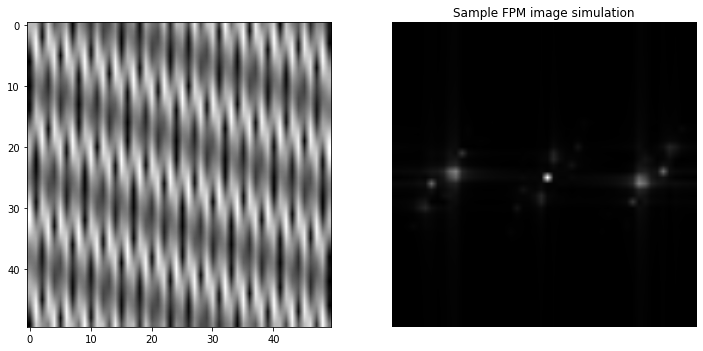

In [3]:
size = 50
simulated_image = SimImage(size=size, max_elements=2, same=True)
simimage = simulated_image.array

fig, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].imshow(np.abs(simimage), cmap='gray', interpolation='bilinear')
axes[1].imshow(np.abs(fftshift(fft2(simimage))), cmap='gray', interpolation='bilinear')
plt.axis('off')
plt.title('Sample FPM image simulation')
plt.show()

Then, the image acquisition process is simulated with the possibility of adition of a noisy camera simulation, incorporating a Poisson process for the photon counting and background and a gaussian for the detection electronic noise.

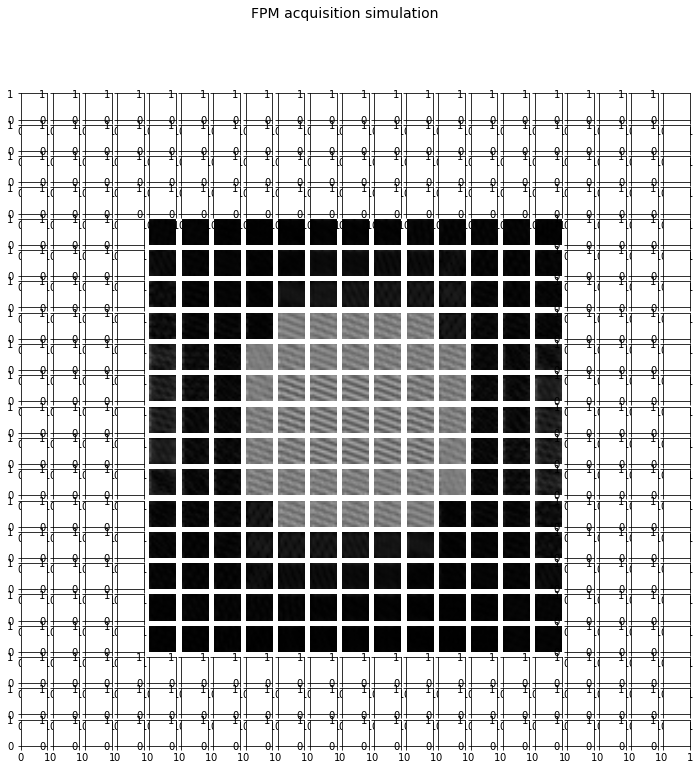

In [4]:
noise_model = NoiseModel(sigmam=[.0, .0])
cfg = data.cfg_load()
sm = SimMicroscope(noise_model=noise_model, cfg=cfg, simulated_image=simimage)
sm.generate_samples()
rm = SimMicroscope.from_dirname(dirname=sm.dirname)
delta_gk, centers = rm.get_phaseopt_input()

## Ploting the simulated captures
nl = 21
fig, axes = plt.subplots(nl, nl, figsize=(12, 12))
iterpoints = sm.iterator()

fim = np.zeros((nl, nl))
for im in delta_gk[:nl**2]:
    p = next(iterpoints)
    axy = p.yp-15+nl//2
    axx = p.xp-15+nl//2
    fim[axx, axy] = np.sum(1/im)
    axes[axx][axy].imshow(np.real(im), cmap='gray', interpolation='bilinear', vmin=0, vmax=cfg.max_photon_flux)
    axes[axx][axy].axis('off')
fig.suptitle('FPM acquisition simulation', fontsize=14)
plt.show()

## Claculating FIM for the simulated acquisition
Let's consider the first case of a Poisson process with no other source of noise than the photon arrival itself. In addition let's take the FIM for the case the only parameter $\theta$ to estimate is $\nu$, the Poisson parameter. In this simplified case, the FIM reduces to a scalar for every image $m$, and results from the addition of the inverse $\nu$ of the $K$ pixels in the image
\begin{equation}
I_m(\theta) = \sum_{k=1}^{K} \frac{1}{\nu_{\theta, k}}
\end{equation}

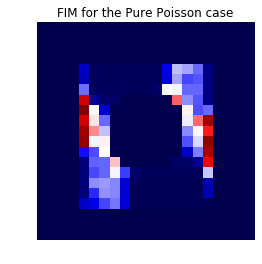

In [5]:
plt.imshow((fim), cmap='seismic')
plt.title('FIM for the Pure Poisson case')
plt.axis('off')
plt.show()

In [6]:
import pandas as pd
df_fim = pd.DataFrame(100*fim)
df_fim = df_fim.applymap('{:.1f}'.format)
df_fim

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,8.7,1.1,1.1,1.1,1.2,1.1,...,1.1,11.5,22.4,21.1,18.1,4.1,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,7.9,1.2,1.1,1.1,1.2,1.1,...,1.1,10.4,21.2,16.3,17.0,3.8,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,18.3,1.2,1.1,1.2,1.2,1.2,...,2.2,25.3,25.0,18.0,17.9,3.8,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,42.9,6.0,2.0,2.0,0.4,0.4,...,0.4,0.4,33.6,19.9,17.0,3.8,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,51.3,25.9,9.8,0.4,0.4,0.4,...,0.4,0.4,0.4,26.4,16.8,18.1,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,43.0,27.0,18.0,0.4,0.4,0.4,...,0.4,0.4,0.4,24.7,33.2,47.6,0.0,0.0,0.0,0.0


## Combined Poisson and Gaussian distribution

We take a Poisson process with parameter $\mu_k$
\begin{equation}
p_1(l) = \frac{e^{-\mu_k} \mu_k^l}{l!},
\end{equation}
and a gaussian distribution $\propto \mathcal{N}(\eta_e, \sigma_e)$ of the like
\begin{equation}
p_g(x) = \frac{1}{\sqrt{2\pi}\sigma_e} e^{\frac{-(x-\eta_e)^2}{2\sigma_e^2}  }.
\end{equation}
If we calculate the distribution of the sum of the random variables $Z=X+L$, the combined PDF will be given as the convolution of the original PDFs
\begin{equation}
p_Z(z) = \sum_{l=0}^{\infty} p_1(l) p_L(z-l),
\end{equation}
so, plugging the previous equations in the last expression, the resulting distribution is obtained
\begin{equation}
pz(z) = \frac{e^{-\mu_k}}{\sqrt{2 \pi} \sigma_e} \sum_{l=0}{\infty} \frac{\mu_k^l}{l!} e^{\frac{-(z-l-\eta_e)^2}{2\sigma_e} }
\end{equation}

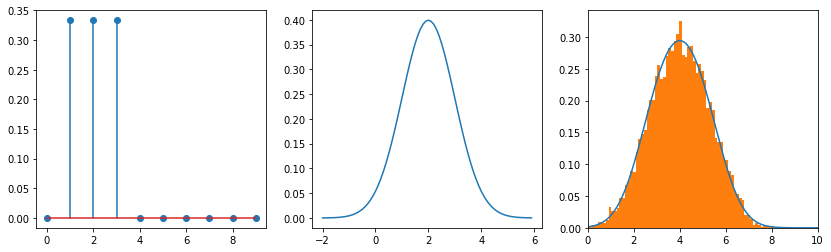

In [6]:
# Combination of random variables
from scipy.stats import poisson, norm
from scipy.integrate import simps

ndisc = 10
step = .1
xd = np.arange(ndisc)
xc = np.arange(-2, 6, step)
pd = np.zeros((ndisc, ))
pd[np.where((xd > 0) * (xd < 4))] = 1/3
# Apply the same step factor to the discrete functionn
n = int(len(pd)/step)
ydc = np.zeros((n, ))
ydc[::int(1/step)] = pd

pc = norm.pdf(xc, 2, 1)
psum = np.convolve(ydc, pc)
xsum = np.arange(len(psum))*step+(xd.min()+xc.min())

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].stem(xd, pd)
axes[1].plot(xc, pc)
axes[2].plot(xsum, psum)
axes[2].set_xlim([0, 10])
samples = np.random.randint(1, 4, 10000)+(np.random.randn(10000)+2)
axes[2].hist(samples, bins=80, density=True)
plt.show()

## Sum of poisson and gaussian 

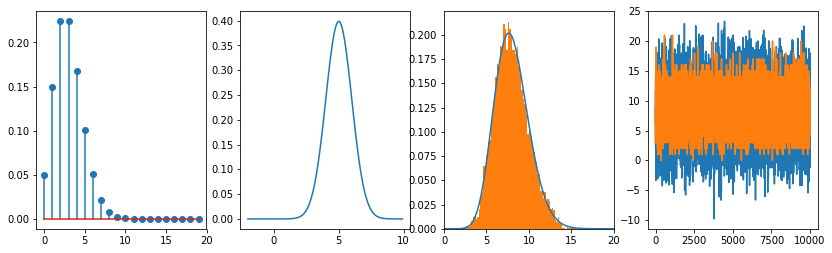

In [7]:
# Combination of random variables
from scipy.stats import poisson, norm

ndisc = 20
step = .1
xd = np.arange(ndisc)
xc = np.arange(-2, 10, step)
pd = poisson.pmf(xd, 3)
# Apply the same step factor to the discrete functionn
n = int(len(pd)/step)
ydc = np.zeros((n, ))
ydc[::int(1/step)] = pd

pc = norm.pdf(xc, 5, 1)
psum = np.convolve(ydc, pc)
xsum = np.arange(len(psum))*step+(xd.min()+xc.min())

fig, axes = plt.subplots(1, 4, figsize=(14, 4))
axes[0].stem(xd, pd)
axes[1].plot(xc, pc)
axes[2].plot(xsum, psum)
axes[2].set_xlim([0, 20])
samples = np.random.poisson(lam=3, size=10000)+np.random.normal(5, 1, 10000)
axes[2].hist(samples, bins=80, density=True)
axes[3].plot(np.random.poisson(lam=3, size=10000)+np.random.normal(5, 4, 10000))
axes[3].plot(np.random.poisson(lam=8, size=10000))


plt.show()

FIM for this case is given by
\begin{equation}
I(\mu_k) = \left( \int_{-\infty}^{\infty} \frac{ \left( \frac{e^{-\mu_k}}{\sqrt{2\pi} \sigma_e}  \sum_{l=1}^{\infty} \frac{\mu_k^{l-1}}{(l-1)!} e^{-\frac{(z-l-\mu_e)^2}{2\sigma_e^2}} \right)^2}{p_{\theta, k}} dz -1 \right)
\end{equation}
And can be calculated numerically from the convolution expression.

/home/juan/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


0.0065261720575324755


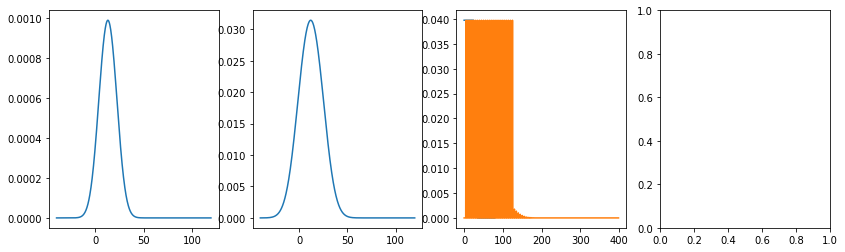

In [25]:
from scipy.integrate import simps
(lp, mue, sige, step) = (15, 0, 10, .2)
def interp(y, step):
    n = int(len(y)/step)
    ydc = np.zeros((n, ))
    ydc[::int(1/step)] = y
    return ydc
nup = lp+5
xd = np.arange(4*nup)
xc = np.arange(mue-4*sige, mue+4*sige, step)
pd = poisson.pmf(xd, nup)
pd[np.where(xd<25)] = 1
pd = pd/np.sum(pd)
nc = norm.pdf(xc, mue, sige)
# Apply the same step factor to the discrete functionn
# Numerator
pd_shift = np.zeros((len(pd)+1))
pd_shift[1:] = pd
pd_shift = pd_shift[:-1]
pc_shift = interp(pd_shift, step)
pc = interp(pd, step)
#FIM
num = np.convolve(pc_shift, nc)**2
den = np.convolve(pc, nc)
xsum = np.arange(len(den))*step+(xd.min()+xc.min())
print(simps(np.nan_to_num(num/den), xsum)-1)
fig, axes = plt.subplots(1, 4, figsize=(14, 4))
axes[0].plot(xsum, num)
axes[1].plot(xsum, den)
axes[2].plot(xd, pd)
axes[2].plot(pc_shift)
plt.show()

/home/juan/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


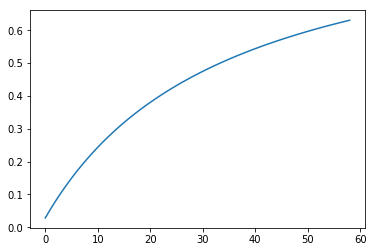

In [69]:
from scipy.integrate import simps
(lp, mue, sige, step) = (2, 0, 10, .2)
def fim(lp, mue, sige, step):
    def interp(y, step):
        n = int(len(y)/step)
        ydc = np.zeros((n, ))
        ydc[::int(1/step)] = y
        return ydc
    nup = lp+30
    xd = np.arange(4*nup)
    xc = np.arange(mue-4*sige, mue+4*sige, step)
    pd = poisson.pmf(xd, nup)
    pd[0:3] = 0
    pd /= np.sum(pd)
    nc = norm.pdf(xc, mue, sige)
    # Apply the same step factor to the discrete functionn
    # Numerator
    pd_shift = np.zeros((len(pd)+1))
    pd_shift[1:] = pd
    pd_shift = pd_shift[:-1]
    pc_shift = interp(pd_shift, step)
    pc = interp(pd, step)
    #FIM
    num = np.convolve(pc_shift, nc)**2
    den = np.convolve(pc, nc)
    xsum = np.arange(len(den))*step+(xd.min()+xc.min())
    return (simps(np.nan_to_num(num/den), xsum)-1)*lp

plt.plot([fim(i, 0, 2, .1) for i in np.arange(1, 60, 1)])